<a href="https://colab.research.google.com/github/Rahulx911/grid-6.0/blob/main/freshness-index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 sample_data  'Screenshot 2024-09-24 at 1.16.29 PM.png'
ls: cannot access 'data': No such file or directory


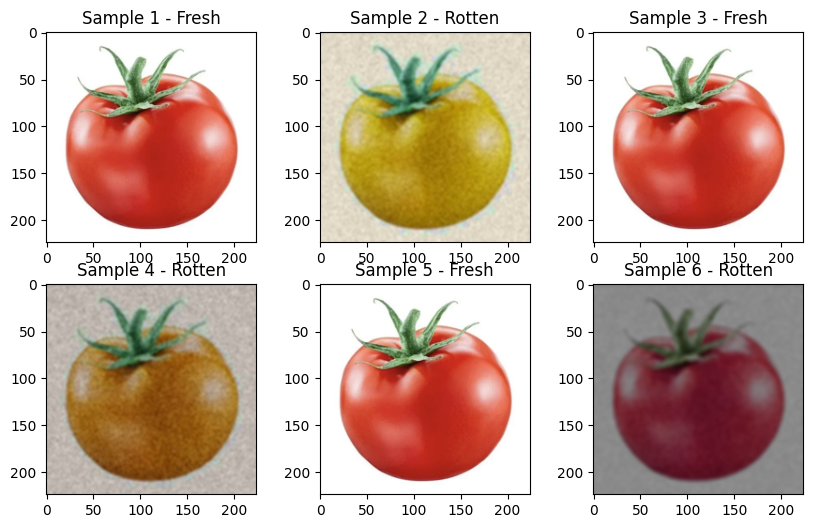

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 732ms/step - accuracy: 0.7505 - loss: 0.6010 - val_accuracy: 0.6667 - val_loss: 0.5080 - learning_rate: 1.0000e-04
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 399ms/step - accuracy: 0.9255 - loss: 0.3909 - val_accuracy: 0.9167 - val_loss: 0.3659 - learning_rate: 1.0000e-04
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 467ms/step - accuracy: 1.0000 - loss: 0.2619 - val_accuracy: 0.9167 - val_loss: 0.2768 - learning_rate: 1.0000e-04
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 506ms/step - accuracy: 1.0000 - loss: 0.1681 - val_accuracy: 0.9167 - val_loss: 0.2447 - learning_rate: 1.0000e-04
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 508ms/step - accuracy: 1.0000 - loss: 0.1144 - val_accuracy: 0.9167 - val_loss: 0.2245 - learning_rate: 1.0000e-04
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 374ms/step - accuracy: 1.0000 - loss: 0.0927 - val_accuracy: 0.9167 - val_loss: 0.1964 - learning_rate: 1.0000e-04
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy

In [7]:
# Install necessary libraries: pip install tensorflow keras albumentations imgaug
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import imgaug.augmenters as iaa
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
!ls # lists files in the current directory
!ls data # lists files in the data directory

# Load the base image (tomato)
image_path = '/content/Screenshot 2024-09-24 at 1.16.29 PM.png' # Change to your actual image path
image = Image.open(image_path)

# Ensure the image has 3 channels (convert RGBA to RGB)
if image.mode == 'RGBA':
    image = image.convert('RGB')

# Resize image to 224x224 for model input
image = np.array(image.resize((224, 224)))

# Define and fine-tune EfficientNet for freshness detection
def create_freshness_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
model = create_freshness_model()

# Augmentor to simulate "rotten" tomatoes with noise, color shifts, etc.
augmentor = iaa.Sequential([
    iaa.Multiply((0.5, 1.5)),  # Adjust brightness
    iaa.AddToHueAndSaturation((-50, 50)),  # Change color
    iaa.AdditiveGaussianNoise(scale=(10, 50)),  # Add noise for rot-like texture
    iaa.GaussianBlur(sigma=(0.0, 3.0))  # Blur for visual degradation
])

# Generate a dataset of 60 images (30 fresh, 30 rotten)
dataset = []
labels = []
for i in range(30):
    fresh_image = image.copy()
    rotten_image = augmentor(image=fresh_image)  # Augment only fresh_image, as now we have only 3 channels

    dataset.append(fresh_image)  # Fresh tomatoes
    labels.append(1)  # Label 1 for fresh

    dataset.append(rotten_image)  # Rotten tomatoes
    labels.append(0)  # Label 0 for rotten

# Convert dataset to numpy arrays for training
X_train = np.array(dataset)
y_train = np.array(labels)

# Display a sample of the dataset
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Sample {i+1} - {'Fresh' if y_train[i] == 1 else 'Rotten'}")
plt.show()

# Train the model with early stopping and learning rate reduction
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Use the .keras format for saving the best model
model_checkpoint = ModelCheckpoint('best_freshness_model.keras', save_best_only=True, monitor='val_loss')

# Train the model on synthetic data
model.fit(X_train, y_train, epochs=20, batch_size=4, validation_split=0.2, callbacks=[lr_reduction, early_stopping, model_checkpoint])

# Evaluate the model
y_pred = model.predict(X_train)
y_pred_labels = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_train, y_pred_labels)
precision = precision_score(y_train, y_pred_labels)
recall = recall_score(y_train, y_pred_labels)
f1 = f1_score(y_train, y_pred_labels)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The tomato is rotten.


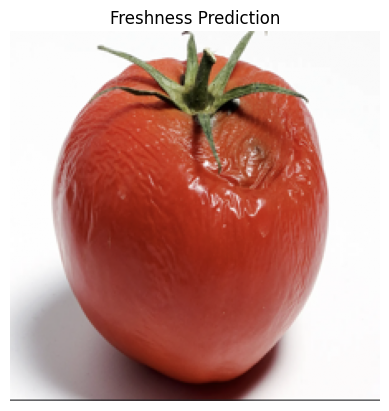

In [12]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained model (assuming the model is saved as 'best_freshness_model.h5')
model = tf.keras.models.load_model('best_freshness_model.keras')

# Function to preprocess the image for the model
def preprocess_image(image_path):
    # Load the image
    image = Image.open(image_path)
    # Ensure the image has 3 channels (convert RGBA to RGB)
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize((224, 224))  # Resize to match model input size
    image = np.array(image)  # Convert to numpy array
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load and preprocess the tomato image
image_path = '/content/Screenshot 2024-09-24 at 1.49.55 PM.png'
image = preprocess_image(image_path)

# Make a prediction
prediction = model.predict(image)

# Determine freshness
if prediction > 0.7:
    print("The tomato is fresh.")
else:
    print("The tomato is rotten.")

# Display the image
plt.imshow(np.squeeze(image))
plt.axis('off')
plt.title("Freshness Prediction")
plt.show()